# Анализ пространственных данных.

Данные для выполнения заданий можно найти [здесь](https://yadi.sk/d/xBemeb0ODlhCAQ?w=1)

Дедлайн: __20 октября 2020 г. 09:00__

ФИО: Акопян Артем Леонидович

Группа: MADE ML-12

## Задание №1. Reading coordinates from a file and creating a geometries. 4 балла.

One of the "classical" problems in GIS is the situation where you have a set of coordinates in a file and you need to get them into a map (or into a GIS-software). Dataset `travelTimes_2015_Helsinki.txt` consist of travel times between specific locations in Helsinki Region.

1. Read the data into memory.
2. Read 4 columns `from_x`, `from_y`, `to_x`, `to_y` from the data.
3. Create two lists called __orig_points__ and __dest_points__
4. Iterate over the rows of your numpy array and add Shapely Point -objects into the __orig_points__ -list and __dest_point__ -list representing the origin locations and destination locations accordingly.

`from_x`: x-coordinate of the __origin__ location (longitude)

`from_y`: y-coordinate of the __origin__ location (latitude)

`to_x`: x-coordinate of the __destination__ location (longitude)

`to_y`: y-coordinate of the __destination__ location (latitude)

In [2]:
# Imports
import haversine
from haversine import haversine, haversine_vector
import geopandas as gpd
import pandas as pd
import numpy as np
import fiona
from shapely import geometry
from shapely.geometry import Point, LineString, Polygon
import math
import pyproj
import os
import earthpy as et
import matplotlib
import matplotlib.pyplot as plt
import descartes
from pysal.viz import mapclassify as mc
import pysal as ps
import pyproj
from pyproj import Geod

In [3]:
# 1. Read the data
path1 = "C:/Users/Artem/Desktop/Geo/HW1_data/travelTimes_2015_Helsinki.txt"
data1 = pd.read_csv(path1, sep = ";", skipinitialspace = True, dtype={'route_total_lines': str})

# 2. Read 4 columns
columns1 = ["from_x", "from_y", "to_x", "to_y"]
df1 = pd.DataFrame(data1[columns1])

# 3. Create lists
orig_points = []
dest_points = []

# 4. Filling the lists
for i in range(len(df1)):
    orig_points.append((df1.iloc[i, 0],
                            df1.iloc[i, 1]))
    dest_points.append((df1.iloc[i, 2],
                            df1.iloc[i, 3]))
    
#print(orig_points, dest_points)

## Задание №2. Creating LineStrings that represent the movements. 6 баллов.

Please use data from previous task:

1. Create a list called `lines`
2. Iterate over the __orig_points__ and __dest_points__ lists and create a Shapely _LineString_ -object between the origin and destination point
3. Add that line into the `lines` -list.
4. Find out what is the average (Euclidian) distance of all the origin-destination _LineStrings_ that we just created, and print it out.

In [16]:
# 1. Create a list called "lines"
lines = []

# 2. Create a LineString
for i in range(len(df1)):
    line = LineString([orig_points[i], dest_points[i]])

    # 3. Add the line to the lines-list
    lines.append(line)

# 4. Find the average distance

# The following value is written just for practice and for comparing the results with chat
# e_distance = sum(line.length for line in lines1) / len(lines1)

h_distance = sum((haversine(line.coords[0][::-1], line.coords[1][::-1]) for line in lines)) / len(lines)

g_distance = sum(pyproj.Geod(ellps='WGS84').inv(df1.iloc[i, 0], df1.iloc[i, 1],
                                                df1.iloc[i, 2], df1.iloc[i, 3])[2] for i in range(len(df1))) / len(df1)

print(f"The average distance of{h_distance} km is calculated with haversine library.")
print(f"Practically the same value is accieved by means of pyproj.Geod {g_distance} km")

The average distance of14.077625758316918 km is calculated with haversine library.
Practically the same value is accieved by means of pyproj.Geod 14120.798266324276 km


## Задание №3. Points to map. 4 балла.

Aim is to plot a set of x and y coordinates that we should read from a `some_posts.csv`. The data has 81379 rows and consists of locations and times of social media posts inside Kruger national park in South Africa.

1. Read the data into memory.
2. Create an empty column called `geometry` where you will store shapely _Point_ objects
3. Iterate over the rows of the DataFrame (__x__ and __y__ -coordinates) and insert _Point_ objects into column `geometry`
4. Convert that DataFrame into a GeoDataFrame
5. Update the CRS for coordinate system as WGS84 (i.e. epsg code: 4326)
6. Save the data into a Shapefile called `Kruger_posts.shp`
7. Create a simple map of those points using .plot() -funtion

`lat`: y-coordinate of the post

`lon`: x-coordinate of the post

`timestamp`: Time when the post was uploaded

`userid`: userid

<AxesSubplot:>

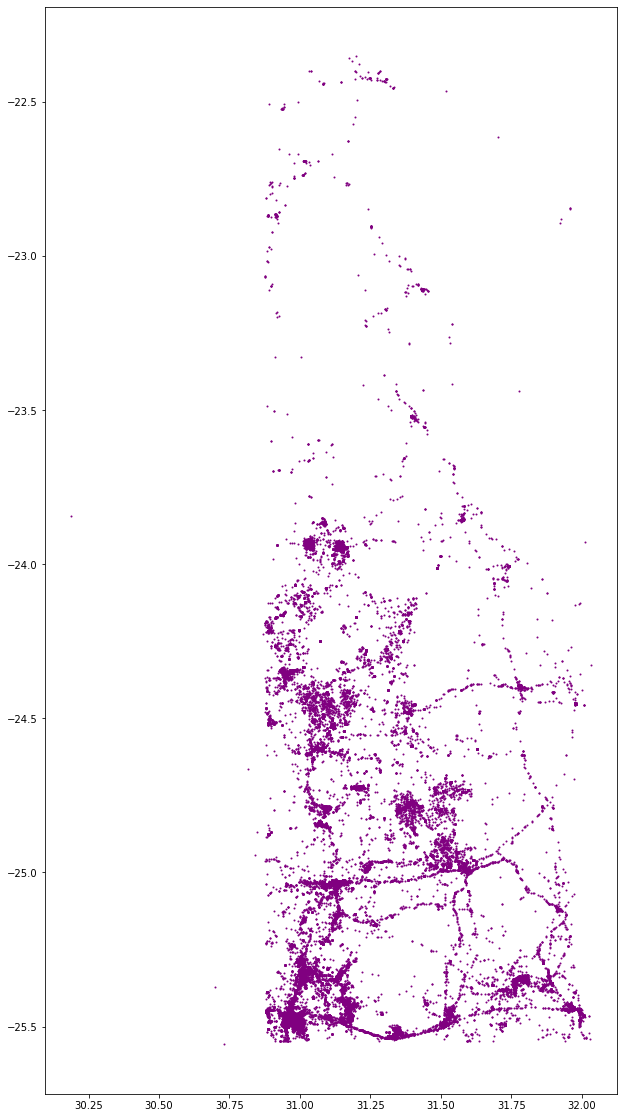

In [8]:
# 1. Read the data
path = "C:/Users/Artem/Desktop/Geo/HW1_data/some_posts.txt"
data = pd.read_csv(path, dtype={'route_total_lines': str})
#print(sum(data.userid.value_counts() > 1)) -> 9026

# 2. Create an empty column
df = data.reindex(data.columns.tolist() + ["geometry"], axis=1) 

# 3. Add Points to geometry
for i in range(len(df)):
    df.at[i, "geometry"] = geometry.Point(df.iloc[i, 1], df.iloc[i, 0])

# 4. Convert to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry = "geometry")

# 5. Update the CRS
gdf = gdf.set_crs("EPSG:4326")

# 6. Writing to a file  "Kruger_posts.shp"
gdf.to_file("Kruger_posts.shp")

# 7. Create a simple map
gdf.plot(figsize = (20, 20), markersize = 1, color = "purple")


## Задание №4. Movements of individual user. 6 баллов.

Please use data from previous task:

1. Group the data by `userid`
2. Create an empty GeoDataFrame
3. For each user:
   - sort the rows by `timestamp`
   - create _LineString_ objects based on the points
   - add the `geometry` and the `userid` into the GeoDataFrame you created in the last step
4. Determine the CRS of your GeoDataFrame to WGS84 (epsg code: 4326)
5. Save the movements of each user into a separate Shapefile
   - Name the output Shapefile based on the `userid` number

In [9]:
# 1. Group by userid
gdf1 = gdf.dissolve(by = "userid")

# 2. Create an empty GeoDataFrame
new_gdf = gpd.GeoDataFrame()

# 3.a Sort users by timestamp, ...
gdf2 = gdf1.sort_values(by = "timestamp")

# 3.b create LineStrings and 3.c add geometry and userid to created GeoDataFrame
l = len(gdf2)
new_gdf = gpd.GeoDataFrame(list(
    # Following condition stands for excluding those objects that turn to Point instead of being a MultiPoint
    (LineString(gdf.iloc[i, 0]) if (type(gdf.iloc[i, 0]) == geometry.MultiPoint) else None, gdf.index[i])
     for i in range(l)),
     columns = ["geometry", "userid"])
new_gdf = new_gdf.dropna()

# 4. Determine CRS
new_gdf.set_crs("EPSG:4326")
#gdf.crs

# 5. Save the movements to .shp files
for i in range(len(new_gdf)):
    f = gpd.GeoDataFrame(new_gdf.iloc[[i]], columns = ["geometry", "userid"])
    name_shp = "track_" + str(new_gdf.iloc[i, 1]) + ".shp"
    f.to_file(name_shp)
    m1 = " is"
    m2 = "s are"
    print(f"File {name_shp} is being saved. Progress: {i + 1} file{m1 if i == 1 else m2} already saved")
# The following condition has been added to stop saving after 5 files are stored
# To evoid this break just comment the following 2 lines of code
    if i == 9:
        break

## Задание №5. Join accessibility datasets into a grid and visualize them by using a classifier. 4 балла.

A dataset from `dataE4.zip` includes 7 text files containing data about accessibility in Helsinki Region and a Shapefile that contains a Polygon grid that can be used to visualize and analyze the data spatially. The datasets are:

 - `travel_times_to_[XXXXXXX]_[NAME-OF-THE-CENTER].txt` including travel times and road network distances to specific shopping center
 - `MetropAccess_YKR_grid_EurefFIN.shp` including the Polygon grid with __YKR_ID__ column that can be used to join the grid with the accessibility data
 
Find out more about the data [here](https://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix-2015/)

1. Read those travel_time data files (one by one) with Pandas and select only following columns from them:

 - `pt_r_tt`
 - `car_r_t`
 - `from_id`
 - `to_id`


2. Visualize the classified travel times (Public transport AND Car) of at least one of the shopping centers using any classification method (see [PySAL](https://pysal.org/) for more details upon classification methods). You need to classify the data into a new column in your GeoDataFrame.

In [19]:
# 1. Read .txt files
direct = r"C:/Users/Artem/Desktop/Geo/HW1_data/dataE4/"
files = ["TravelTimes_to_5878070_Jumbo",
        "TravelTimes_to_5878087_Dixi",
        "TravelTimes_to_5902043_Myyrmanni",
        "TravelTimes_to_5944003_Itis",
        "TravelTimes_to_5975373_Forum",
        "TravelTimes_to_5978593_Iso_omena",
        "TravelTimes_to_5980260_Ruoholahti",
        "MetropAccess_YKR_grid_EurefFIN"]

trade_centers = ["Jumbo", "Dixi", "Myyrmanni", "Itis", "Forum", "Iso_omena", "Ruoholahti"]
columns = ["pt_r_tt", "car_r_t", "from_id", "to_id", "x", "y", "YKR_ID", "geometry"]

# We create two empty arrays for dataframes and geodataframes
dfs = []
gdfs = []

# We put "-1" because the last file name would be used later
for file in files[0:-1]:
    df = pd.read_csv(direct + file + ".txt", sep = ";", usecols = columns[0:4])
    dfs.append(df)
    
access_data = gpd.read_file(direct + files[-1] + ".shp") 

# We create Geodataframes for every center
for df in dfs:
    gdf = df.merge(access_data, left_on = "from_id", right_on = "YKR_ID")
    gdfs.append(gpd.GeoDataFrame(gdf))
    
# In the following code block we've been looking for the outliers
'''
for i in range(6):
    print(gdfs[i]["pt_r_tt"].unique())

for i in range(6):
    print(gdfs[i]["car_r_t"].unique())

for i in range(6):
    print(gdfs[i]["to_id"].unique())

for i in range(6):
    print(gdfs[i]["x"].unique())

for i in range(6):
    print(gdfs[i]["y"].unique())
'''

# Then we drop accordingly to our observation outliers (objects with negative ids). In visualization devoted
# blocks the procedure would be repeated for time observations.

for i in range(len(gdfs)):
    index_to_id = gdfs[i][gdfs[i]["to_id"] < 0].index
    gdfs[i].drop(index_to_id, inplace = True)
    
# For further analytics we can use any trade center.
# For this task I choose "Itis" and pick therfore the number "3" for
# following calculations

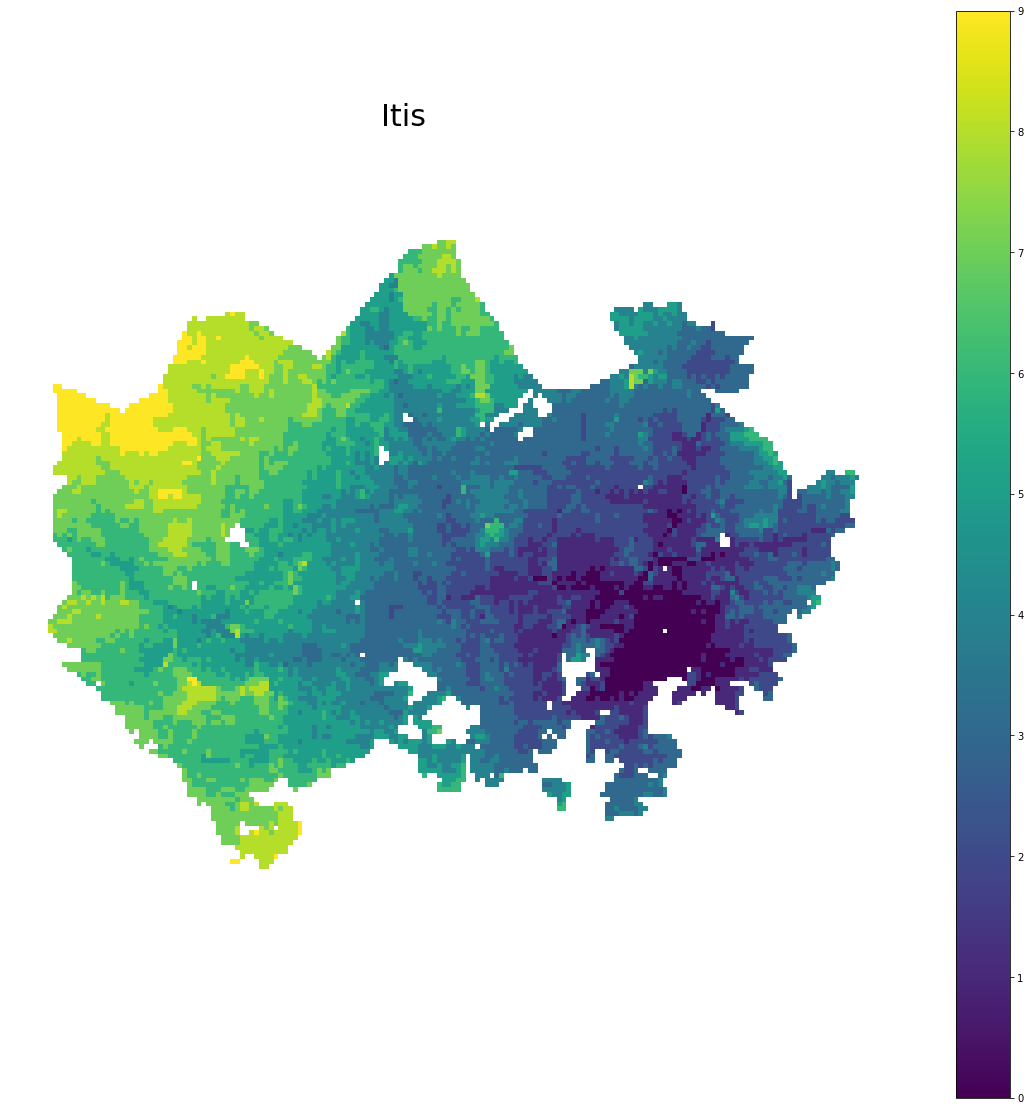

In [20]:
N = 3
n_class = 10
for i in range(len(gdfs)):
    index_car_r_t = gdfs[i][gdfs[i]["car_r_t"] < 0].index
    gdfs[i].drop(index_car_r_t, inplace = True)

    
# 2. Classify and...
classifier = mc.NaturalBreaks.make(k = n_class)
gdfs[N]['access_zones'] = gdfs[N][["car_r_t"]].apply(classifier)

# 2. ... visualize the data for car's and...
f, ax = plt.subplots(1, figsize=(20, 20))
gdfs[N].plot(column = "access_zones", ax = ax, legend = True)
ax.set_axis_off()
plt.figtext(.4,.8,trade_centers[N], fontsize = 30, ha = "center")

plt.show()

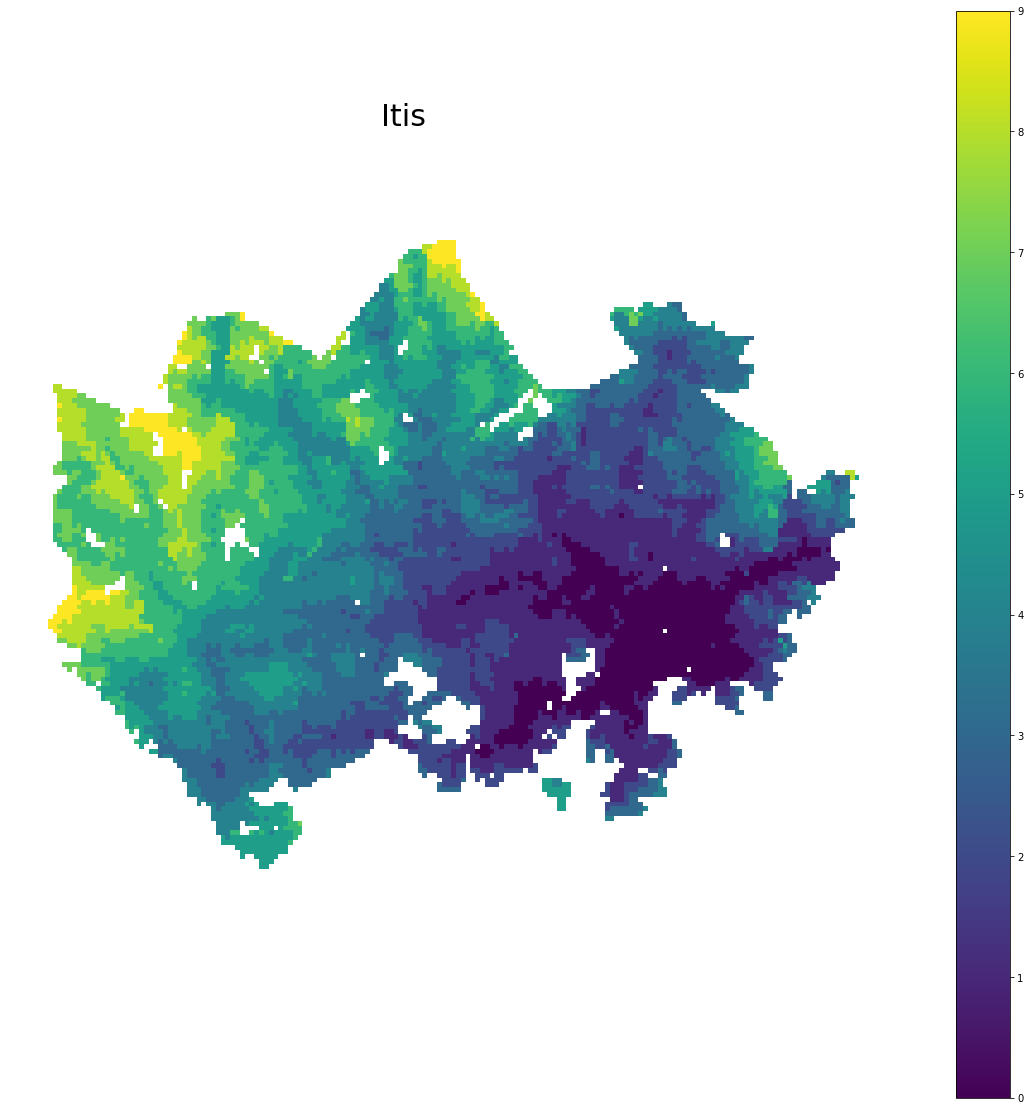

In [21]:
N = 3
n_class = 10
for i in range(len(gdfs)):
    index_pt_r_tt = gdfs[i][gdfs[i]["pt_r_tt"] < 0].index
    gdfs[i].drop(index_pt_r_tt, inplace = True)

# ... and the same for public transport
classifier = mc.NaturalBreaks.make(k = n_class)
gdfs[N]['access_zones'] = gdfs[N][["pt_r_tt"]].apply(classifier)

f, ax = plt.subplots(1, figsize=(20, 20))
gdfs[N].plot(column = "access_zones", ax = ax, legend = True)
ax.set_axis_off()
plt.figtext(.4,.8,trade_centers[N], fontsize = 30, ha = "center")

plt.show()

## Задание №6. Calculate and visualize the dominance areas of shopping centers. 6 баллов.

Please use data from previous task. The aim is to define the dominance area for each of those shopping centers based on travel time:

1. Iterate over the accessibility files one by one
2. Rename the travel time columns so that they can be identified
   - you can include e.g. the `to_id` number as part of the column name (then the column name could be e.g. "pt_r_tt_5987221")
3. Join those columns into `MetropAccess_YKR_grid_EurefFIN.shp` where __YKR_ID__ in the grid corresponds to `from_id` in the travel time data file. At the end you should have a GeoDataFrame with different columns show the travel times to different shopping centers.
4. For each row find out the __minimum__ value of __all__ `pt_r_tt_XXXXXX` columns and insert that value into a new column called `min_time_pt`. You can now also parse the `to_id` value from the column name (i.e. parse the last number-series from the column text) that had the minimum travel time value and insert that value as a number into a column called `dominant_service`. In this, way are able to determine the "closest" shopping center for each grid cell and visualize it either by travel times or by using the __YKR_ID__ number of the shopping center (i.e. that number series that was used in column name).
5. Visualize the travel times of our `min_time_pt` column using any classifier.
6. Visualize also the values in `dominant_service` column (no need to use any specific classifier). Notice that the value should be a number. If it is still as text, you need to convert it first.

In [22]:
# We prepare all the necessary data info about the map and our objects
# as in the previous task

direct = r"C:/Users/Artem/Desktop/Geo/HW1_data/dataE4/"
files = ["TravelTimes_to_5878070_Jumbo",
        "TravelTimes_to_5878087_Dixi",
        "TravelTimes_to_5902043_Myyrmanni",
        "TravelTimes_to_5944003_Itis",
        "TravelTimes_to_5975373_Forum",
        "TravelTimes_to_5978593_Iso_omena",
        "TravelTimes_to_5980260_Ruoholahti",
        "MetropAccess_YKR_grid_EurefFIN"]

ids = ["_5878070", "_5878087", "_5902043", "_5944003", "_5975373", "_5978593", "_5980260"]
trade_centers = ["Jumbo", "Dixi", "Myyrmanni", "Itis", "Forum", "Iso_omena", "Ruoholahti"]
columns = ["pt_r_tt", "car_r_t", "from_id", "to_id", "x", "y", "YKR_ID", "geometry"]

# We create two empty arrays for dataframes and geodataframes
dfs = []
gdfs = []
indecies = []

for file in files[: -1]:
    df = pd.read_csv(direct + file + ".txt", sep = ";", usecols = columns[0:4])
    dfs.append(df)
    
access_data = gpd.read_file(direct + files[-1] + ".shp") 

# We create Geodataframes for every center
for df in dfs:
    gdf = df.merge(access_data, left_on = "from_id", right_on = "YKR_ID")
    gdfs.append(gpd.GeoDataFrame(gdf))
    
# We clean the data from the outliers
for i in range(len(dfs)):
    index_to_id = dfs[i][dfs[i]["to_id"] < 0].index
    dfs[i].drop(index_to_id, inplace = True)
    index_pt_r_tt = dfs[i][dfs[i]["pt_r_tt"] < 0].index
    dfs[i].drop(index_pt_r_tt, inplace = True)
    index_car_r_t = dfs[i][dfs[i]["car_r_t"] < 0].index
    dfs[i].drop(index_car_r_t, inplace = True)

# 1. & 2. Iterating through files we rename the columns respectively
for i in range(len(dfs)):
    new_names = list(col_name + ids[i] for col_name in dfs[i].columns.tolist()) # We convert the column names
    dfs[i].columns = new_names# And replace the old ones
    indecies.append(7 + (i * 4))

# 3. We join the columns to GeoDataFrame
for df in dfs:
    access_data = access_data.merge(df, left_on = "YKR_ID", right_on = df.columns[0])

# 4. Create and fill the columns "min_time_pt" and "dominant_service"
access_data = access_data.reindex(access_data.columns.tolist() + ["min_time_pt", "dominant_service"], axis = 1)
for i in range(len(access_data)):
    t = 9999
    dom_service = ""
    for j in indecies:
        if access_data.iloc[i, j] < t:
            t = access_data.iloc[i, j]
            dom_service = access_data.iloc[i, j - 2]
    access_data.iloc[i, -2] = t
    access_data.iloc[i, -1] = dom_service

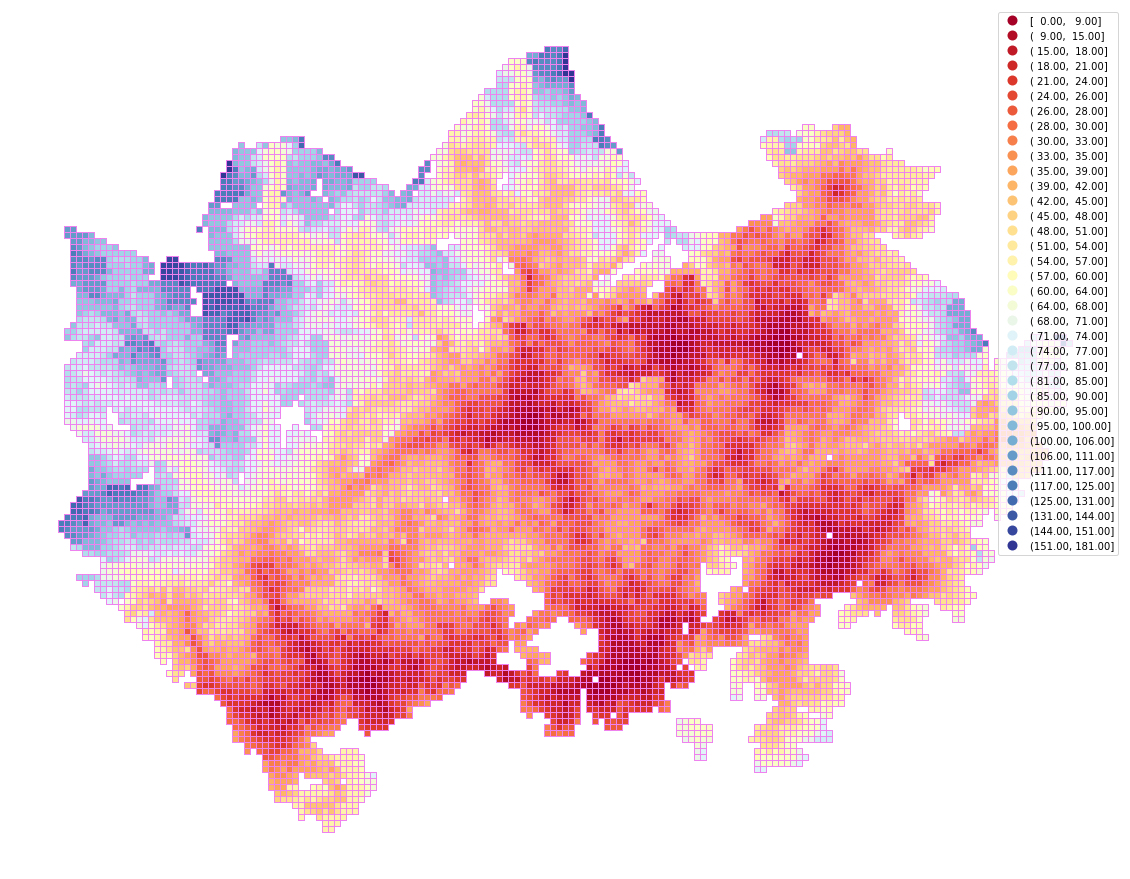

In [23]:
# 5. Visualize travel times by min_time_pt
f, ax = plt.subplots(1, figsize=(20, 20))
access_data.plot(column = "min_time_pt", scheme = "Natural_Breaks", k = 36, cmap = "RdYlBu", ax = ax,
        edgecolor = "violet", legend = True)
ax.set_axis_off()
plt.show()

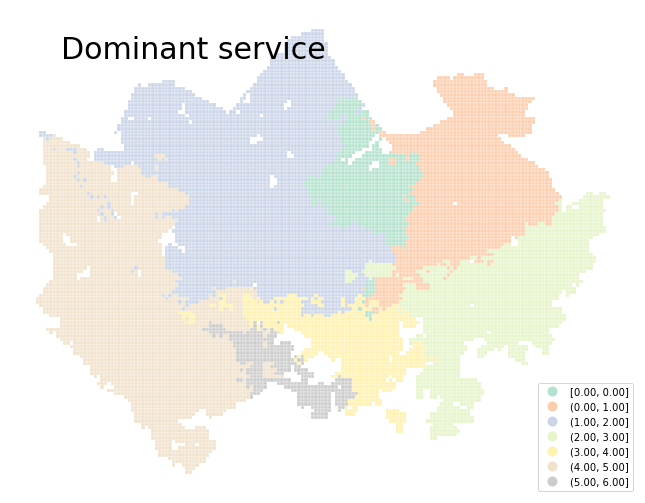

In [148]:
# 6. Visualize travel times by min_time_pt
classifier = mc.NaturalBreaks(access_data[["dominant_service"]], k = 7)

f, ax = plt.subplots(1, figsize=(16, 9))
access_data.assign(dominant_service = classifier.yb).plot(column = "dominant_service", categorical=True, k = 7,
                                                          cmap = "Pastel2", scheme = "Natural_Breaks", ax = ax,
                                                          edgecolor = "white", linewidth = 0.3, legend = True,
                                                          legend_kwds = {'loc': 'lower right'})
ax.set_axis_off()
plt.figtext(.4, .8, "Dominant service", fontsize = 30, ha = "center")

plt.show()